<a href="https://colab.research.google.com/github/SoheilBadri2000/hoSKlearnKerasTensorflow/blob/main/ch03ex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
# Imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import fetch_openml
from sklearn.model_selection  import GridSearchCV, cross_val_score, train_test_split
from scipy.ndimage import shift
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request
import tarfile
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import email
import email.policy
from collections import Counter
import re
from html import unescape
import nltk
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.sparse import csr_matrix
%pip install -q -U urlextract
import urlextract
from scipy.sparse import csr_matrix

# 1. MNIST

In [150]:
# MNIST Data
mnist = fetch_openml("mnist_784", as_frame=False)
X, y = mnist.data, mnist.target
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [151]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9688

In [152]:
param_grid = [{"weights": ["uniform", "distance"], "n_neighbors": [3, 4, 5, 6]}]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5)
grid_search.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [153]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [154]:
grid_search.best_score_

0.9441999999999998

In [155]:
grid_search.best_estimator_.fit(X_train, y_train)
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

# 2. Data Augmentation

In [156]:
def plot_digit(image_data):
  image = image_data.reshape(28, 28)
  plt.imshow(image, cmap="binary")
  plt.axis("off")

In [157]:
def shift_image(image_data, dx, dy):
  image = image_data.reshape(28, 28)
  shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
  return shifted_image.reshape([-1])

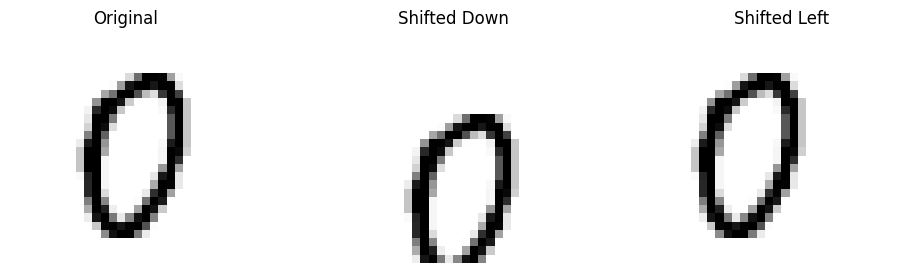

In [158]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131, title="Original")
plot_digit(image)
plt.subplot(132, title="Shifted Down")
plot_digit(shifted_image_down)
plt.subplot(133, title="Shifted Left")
plot_digit(shifted_image_left)

In [159]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
  for image, label in zip(X_train, y_train):
    X_train_augmented.append(shift_image(image, dx, dy))
    y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [160]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [161]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [162]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [163]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

In [164]:
error_rate_change = (1 - augmented_accuracy) / (1 - tuned_accuracy) - 1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -17%


# 3. Tackle the Titanic dataset

In [165]:
def load_titanic_data():
  tarball_path = Path("datasets/titanic.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/titanic.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as titanic_tarball:
      titanic_tarball.extractall(path="datasets")
  return [pd.read_csv(Path("datasets/titanic") / filename) for filename in ("train.csv", "test.csv")]

In [166]:
train_data, test_data = load_titanic_data()

In [167]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [168]:
test_data.shape

(418, 11)

In [169]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [170]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [171]:
train_data[train_data["Sex"] == "female"]["Age"].median()

27.0

In [172]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699113,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526507,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [173]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [174]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [175]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [176]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [177]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [178]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipeline = Pipeline([
    ("ordinal_encoder", OrdinalEncoder()),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("cat_encoder", OneHotEncoder(sparse=False))
])

In [179]:
num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [180]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[-0.56573582,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.6638609 ,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.10463705,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833664, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276213, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [181]:
y_train = train_data["Survived"]

In [182]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [183]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

In [184]:
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8137578027465668

In [185]:
svm_clf = SVC(gamma = "auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

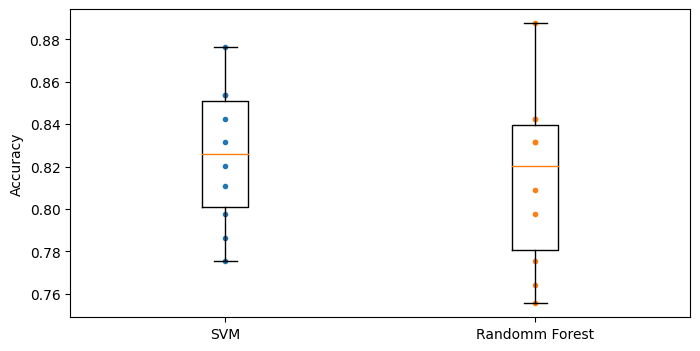

In [186]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM", "Randomm Forest"))
plt.ylabel("Accuracy")
plt.show()

# 4. Spam Classifier

In [187]:
def fetch_spam_data():
  spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
  ham_url = spam_root + "20030228_easy_ham.tar.bz2"
  spam_url = spam_root + "20030228_spam.tar.bz2"

  spam_path = Path() / "datasets" / "spam"
  spam_path.mkdir(parents=True, exist_ok=True)
  for dir_name, tar_name, url in (("easy_ham", "ham", ham_url), ("spam", "spam", spam_url)):
    if not (spam_path / tar_name).is_dir():
      path = (spam_path / tar_name).with_suffix(".tar.bz2")
      print("Downloading", path)
      urllib.request.urlretrieve(url, path)
      tar_bz2_file = tarfile.open(path)
      tar_bz2_file.extractall(path=spam_path)
      tar_bz2_file.close()
  return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [188]:
ham_dir, spam_dir = fetch_spam_data()

In [189]:
ham_dir

PosixPath('datasets/spam/easy_ham')

In [190]:
spam_dir

PosixPath('datasets/spam/spam')

In [191]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [192]:
ham_filenames[:5]

[PosixPath('datasets/spam/easy_ham/00001.7c53336b37003a9286aba55d2945844c'),
 PosixPath('datasets/spam/easy_ham/00002.9c4069e25e1ef370c078db7ee85ff9ac'),
 PosixPath('datasets/spam/easy_ham/00003.860e3c3cee1b42ead714c5c874fe25f7'),
 PosixPath('datasets/spam/easy_ham/00004.864220c5b6930b209cc287c361c99af1'),
 PosixPath('datasets/spam/easy_ham/00005.bf27cdeaf0b8c4647ecd61b1d09da613')]

In [193]:
spam_filenames[:5]

[PosixPath('datasets/spam/spam/00001.7848dde101aa985090474a91ec93fcf0'),
 PosixPath('datasets/spam/spam/00002.d94f1b97e48ed3b553b3508d116e6a09'),
 PosixPath('datasets/spam/spam/00003.2ee33bc6eacdb11f38d052c44819ba6c'),
 PosixPath('datasets/spam/spam/00004.eac8de8d759b7e74154f142194282724'),
 PosixPath('datasets/spam/spam/00005.57696a39d7d84318ce497886896bf90d')]

In [194]:
len(ham_filenames)

2500

In [195]:
len(spam_filenames)

500

In [196]:
def load_email(filepath):
  with open(filepath, "rb") as f:
    return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [197]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

In [198]:
ham_emails[:5]

In [199]:
spam_emails[:5]

In [200]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [201]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [202]:
def get_email_structure(email):
  if isinstance(email, str):
    return email
  payload = email.get_payload()
  if isinstance(payload, list):
    multipart = ", ".join([get_email_structure(sub_email) for sub_email in payload])
    return f"multipart({multipart})"
  else:
    return email.get_content_type()

In [203]:
def structures_counter(emails):
  structures = Counter()
  for email in emails:
    structure = get_email_structure(email)
    structures[structure] += 1
  return structures

In [204]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [205]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [206]:
for header, value in spam_emails[0].items():
  print(header, ":", value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

In [207]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [208]:
X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2400,) (2400,)
(600,) (600,)


In [210]:
# There would have been an easier way to parse with BeautifulSoup
def html_to_plain_text(html):
  text = re.sub("<head.*?>.*?</head>", "", html, flags=re.M | re.S | re.I)
  text = re.sub("<a\s.*?>", " HYPERLINK ", text, flags=re.M | re.S | re.I)
  text = re.sub("<.*?>", "", text, flags=re.M | re.S)
  text = re.sub(r"(\s*\n)+", "\n", text, flags=re.M |re.S)
  return unescape(text)

In [211]:
html_spam_email = [email for email in X_train[y_train==1] if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_email[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [212]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [213]:
def email_to_text(email):
  html = None
  for part in email.walk():
    ctype = part.get_content_type()
    if not ctype in ("text/plain", "text/html"):
      continue
    try:
      content = part.get_content()
    except: # in case of encoding issues
      content = str(part.get_payload())
    if ctype == "text/plain":
      return content
    else:
      html = content
  if html:
    return html_to_plain_text(html)

In [214]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [215]:
stemmer = nltk.PorterStemmer()
for word in ("Commputation", "Computation", "Computing", "Computed", "Compute", "Compulsive"):
  print(word, "=>", stemmer.stem(word))

Commputation => commput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [216]:
url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [217]:
class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
               replace_urls=True, replace_numbers=True, stemming=True):
    self.strip_headers = strip_headers
    self.lower_case = lower_case
    self.remove_punctuation = remove_punctuation
    self.replace_urls = replace_urls
    self.replace_numbers = replace_numbers
    self.stemming = stemming
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    X_transformed = []
    for email in X:
      text = email_to_text(email) or ""
      if self.lower_case:
        text = text.lower()
      if self.replace_urls and url_extractor is not None:
        urls = list(set(url_extractor.find_urls(text)))
        urls.sort(key=lambda url: len(url), reverse=True)
        for url in urls:
          text = text.replace(url, " URL ")
      if self.replace_numbers:
        text = re.sub(r"\d+(?:\.\d*)?(?:[eE][+-]?\d+)?", "NUMBER", text)
      if self.remove_punctuation:
        text = re.sub(r"\W+", " ", text, flags=re.M)
      word_counts = Counter(text.split())
      if self.stemming and stemmer is not None:
        stemmed_word_counts = Counter()
        for word, count in word_counts.items():
          stemmed_word = stemmer.stem(word)
          stemmed_word_counts[stemmed_word] += count
        word_counts = stemmed_word_counts
        X_transformed.append(word_counts)
      return np.array(X_transformed)

In [218]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1})],
      dtype=object)

In [219]:
class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
  def __init__(self, vocabulary_size=1000):
    self.vocabulary_size = vocabulary_size
  def fit(self, X, y=None):
    total_count = Counter()
    for word_count in X:
      for word, count in word_count.items():
        total_count[word] += min(count, 10)
    most_common = total_count.most_common()[:self.vocabulary_size]
    self.vocabulary_ = {word: index+1 for index, (word, count) in enumerate(most_common)}
    return self
  def transform(self, X, y=None):
    rows = []
    cols = []
    data = []
    for row, word_count in enumerate(X):
      for word, count in word_count.items():
        rows.append(row)
        cols.append(self.vocabulary_.get(word, 0))
        data.append(count)
    return csr_matrix((data,(rows, cols)), shape=(len(X), self.vocabulary_size +1))

In [220]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<1x11 sparse matrix of type '<class 'numpy.int64'>'
	with 6 stored elements in Compressed Sparse Row format>

In [221]:
X_few_vectors.toarray()

array([[0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]])

In [222]:
vocab_transformer.vocabulary_

{'chuck': 1, 'murcko': 2, 'wrote': 3, 'stuff': 4, 'yawn': 5, 'r': 6}